# 📈 ETH/USD Price Prediction & Trade Signal Generator
Este notebook permite entrenar, actualizar y usar un modelo RNN para predecir el precio de ETH/USD.
Además, genera señales de trading basadas en predicciones futuras (comprar, vender o mantener).

In [1]:
# 🔧 Librerías
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
from datetime import datetime


2025-04-14 19:35:54.277775: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-14 19:35:54.287747: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744652154.299681   11037 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744652154.303109   11037 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744652154.312165   11037 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [39]:
# ⚙️ Función para cargar los datos históricos
SYMBOL = "ETHUSDT"
INTERVAL = "1h"
LIMITE = 1000
def load_data(symbol=SYMBOL, interval=INTERVAL, limit=LIMITE):
    url = f"https://api.binance.com/api/v3/klines?symbol={symbol}&interval={interval}&limit={limit}"
    df = pd.read_json(url)
    df.columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume',
                  'close_time', 'quote_asset_volume', 'number_of_trades',
                  'taker_buy_base_volume', 'taker_buy_quote_volume', 'ignore']
    df['date'] = pd.to_datetime(df['timestamp'], unit='ms')
    df['close'] = df['close'].astype(float)
    df.set_index('date', inplace=True, drop=False)
    return df[['close']]

In [3]:
def create_windows_np(data, window_size, horizon, shuffle=False):
    """
    Creates a dataset from the given time series data using NumPy.

    Parameters:
    data (np.ndarray): Time series data with one dimension.
    window_size (int): The number of past time steps to use as input features.
    horizon (int): The number of future time steps to predict.
    shuffle (bool): Shuffle the windows or not.

    Returns:
    tuple: A tuple containing the input-output pairs (windows, targets) as NumPy arrays.
    """

    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size+horizon-1])

    X, y = np.array(X), np.array(y)

    if shuffle:
        indices = np.arange(len(X))
        np.random.shuffle(indices)
        X, y = X[indices], y[indices]

    return X, y


In [29]:
def normalize_data(train_data, test_data):
    mu = train_data.mean()
    sigma = train_data.std()

    train_data = (train_data - mu) / sigma
    test_data = (test_data - mu) / sigma


    return train_data, test_data, mu, sigma

In [5]:
# 🧠 Crear el modelo RNN
def build_model(window_size):
    inputs = keras.Input(shape=(window_size, 1))
    x = layers.Conv1D(32, 3, activation='relu')(inputs)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Bidirectional(layers.LSTM(16, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(16, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(16))(x)
    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
    return model

In [7]:
# 🔮 Hacer predicción futura
def predict_next_price(model, last_window):
    return model.predict(last_window)[0][0]

In [71]:
# 📊 Generar señal de trading según predicción
def generate_trade_signal(current_price, predicted_price, threshold=0.03):
    change = (predicted_price - current_price) / current_price
    print(change)
    if change > threshold:
        return 'BUY'
    elif change < -threshold:
        return 'SELL'
    else:
        return 'HOLD'

In [70]:
# 🧪 Ejemplo de uso

# Cargar datos
df = load_data(symbol=SYMBOL, interval=INTERVAL, limit=LIMITE)

# Crear o cargar modelo
#model = build_model(window_size)
#model = keras.models.load_model('/home/eprdz/cryptoAI/eth.keras')  # Descomentar si ya tienes uno entrenado

# Entrenar
#model.fit(X, y, epochs=10, batch_size=64, validation_split=0.2)
#model.save('eth_rnn_model.h5')

In [53]:
# Train-test split
test_date = pd.Timestamp("2025-04-12")
init_date = pd.Timestamp("2019-01-01")

# train_data = df_coin.loc[df_coin.index < test_date].values

train_data = df.loc[(df.index < test_date) *
                         (df.index > init_date)].values

test_data = df.loc[df.index >= test_date].values

In [56]:
train_data, test_data, mu, sigma = normalize_data(train_data, test_data)


In [64]:
df.loc[df.index >= test_date]

,close
date,
2025-04-12 00:00:00,1562.25
2025-04-12 01:00:00,1554.68
2025-04-12 02:00:00,1547.76
2025-04-12 03:00:00,1554.40
2025-04-12 04:00:00,1567.52
...,...
2025-04-14 13:00:00,1658.38
2025-04-14 14:00:00,1673.40
2025-04-14 15:00:00,1627.93


In [50]:
# Create windows
window_size = 12
horizon = 48
X_train, y_train = create_windows_np(train_data, window_size, horizon, shuffle=True)
X_test, y_test = create_windows_np(test_data, window_size, horizon, shuffle=False)

In [84]:
model.fit(X_train, y_test, epochs=10, batch_size=64, validation_split=0.2)

array([[-1.17822294],
       [-1.22988744],
       [-1.27711574],
       [-1.23179841],
       [-1.14225572],
       [-1.13515783],
       [-1.09905411],
       [-1.04308993],
       [-0.97682015],
       [-0.93764523],
       [-0.97504568],
       [-0.96112288],
       [-0.8713072 ],
       [-0.65604986],
       [-0.55306212],
       [-0.53927583],
       [-0.62219836],
       [-0.68976487],
       [-0.57483355],
       [-0.6296375 ],
       [-0.58452491],
       [-0.59742397],
       [-0.58036172],
       [-0.6190589 ],
       [-0.6332547 ],
       [-0.80380894],
       [-0.74723052],
       [-0.75316819],
       [-0.85915888],
       [-0.85724791],
       [-0.80462793],
       [-0.82844683],
       [-0.77999004],
       [-0.7353552 ],
       [-0.79828077],
       [-0.89137241],
       [-0.89983528],
       [-1.0962559 ],
       [-1.01606333],
       [-1.01190014],
       [-0.9499983 ],
       [-0.66963141],
       [-0.71610898],
       [-0.98712575],
       [-0.98364505],
       [-0

In [68]:
model.fit(X_train, y_train, epochs=10, batch_size=64)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.6482
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5968
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5228
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4878
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5014
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5361
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4773
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5252
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5228
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5034


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
max deviation:  96.22694824218752
RMSE:  54.35357930628217
MAE:  46.84279506138397


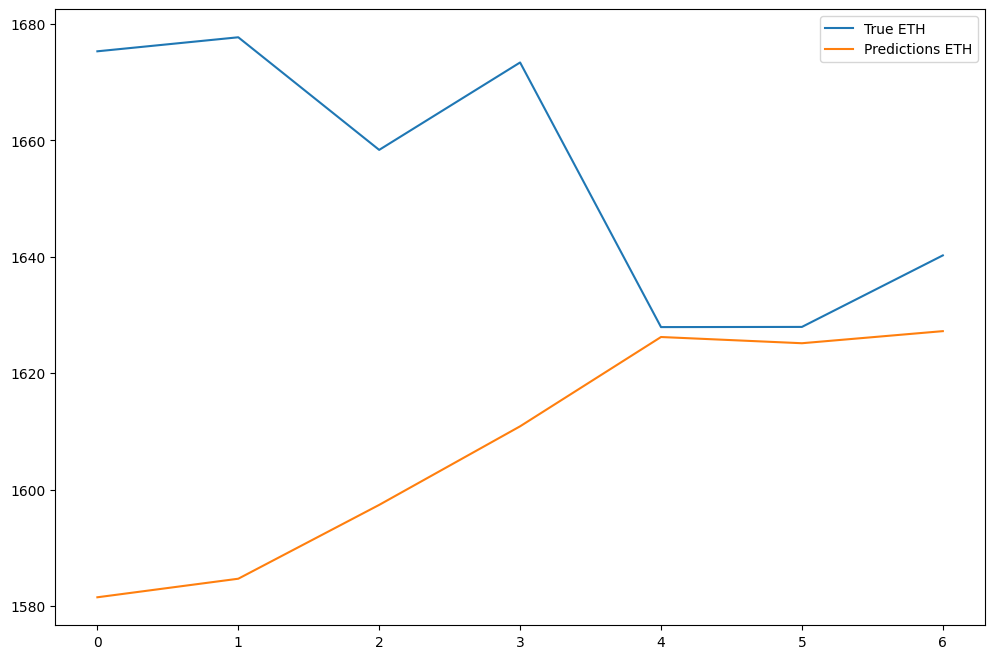

In [86]:
y_pred = model.predict(X_test).flatten() * sigma + mu
y_target = y_test * sigma + mu
diff = y_pred - y_target

print('max deviation: ', np.abs(y_pred - y_target).max())
print('RMSE: ', np.mean((y_pred - y_target)**2)**0.5)
print('MAE: ', np.abs(y_pred - y_target).mean())

plt.figure(figsize=(12, 8))
plt.plot(y_target)
plt.plot(y_pred)

plt.legend(['True {0}'.format("ETH"), 'Predictions {0}'.format("ETH")])
plt.show()

In [ ]:
# 🚀 Predecir y generar señal
last_window = X[-window_size:]
current_price = X_norm[-1] * sigma + mu
predicted_price = predict_next_price(model, last_window) * sigma + mu
signal = generate_trade_signal(current_price, predicted_price)

print(f'Current price: {current_price:.2f}')
print(f'Predicted next price: {predicted_price:.2f}')
print(f'Trade signal: {signal}')

## Updates to update model and use it with new data

In [ ]:
# ====== CONFIGURACIÓN ======
WINDOW_SIZE = 12
MODELO_PATH = "eth_rnn_model.h5"
BASE_SAVE_PATH = "eth_rnn_model"

# ====== FUNCIONES ======

def filtrar_datos_nuevos(df, ultima_fecha):
    return df[df['date'] > ultima_fecha]

def crear_ventanas(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

def actualizar_modelo(modelo, df_nuevo, window_size):
    serie = df_nuevo['close'].values
    X_nuevo, y_nuevo = crear_ventanas(serie, window_size)
    if len(X_nuevo) == 0:
        print("⚠️ No hay datos suficientes nuevos para actualizar.")
        return modelo
    X_nuevo = X_nuevo.reshape((X_nuevo.shape[0], X_nuevo.shape[1], 1))
    modelo.fit(X_nuevo, y_nuevo, epochs=5, batch_size=32, verbose=1,
               callbacks=[
                   keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=2, min_lr=1e-6),
                   keras.callbacks.EarlyStopping(monitor='loss', patience=3)
               ])
    return modelo

def guardar_modelo_con_fecha(model, base_path=BASE_SAVE_PATH):
    fecha = datetime.now().strftime('%Y%m%d_%H%M')
    ruta = f"{base_path}_{fecha}.h5"
    model.save(ruta)
    print(f"✅ Modelo guardado en: {ruta}")